<a href="https://colab.research.google.com/github/PDDA-OPDU/MICP-Analytics/blob/main/Auto_Chicheng_GitHub/Panel_Bvocc_ver4_optimization_read_Chicheng_ver7_full_auto_GitHub.ipynb" 
    target="_parent"><img 
    src="https://colab.research.google.com/assets/colab-badge.svg" 
    alt="Open In Colab"/></a>

In [1]:
using_colab = True

In [2]:
if using_colab:


    !wget 'https://github.com/PDDA-OPDU/MICP-Analytics/raw/main/Auto_Chicheng_GitHub/CORE_DATA_AND_DESCRIPTIONS_DATABASE_HPMI.xlsx'
    #!wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/photos.ZIP'

    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/STELLA_brief_ver2_backyard_grass_shoreline.ipynb
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_grass_shade_whiteshade.xlsx
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_FullSun.xlsx

    #!pip install altair
    #!pip install panel
    #!pip install pillow
    #!pip install jupyter_bokeh
    #!pip install altair_viewer
    #!pip install altair_transform
    !pip install scipy

    #!unzip photos


# Gaussian Fit of HPMI data

## Load Python libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import panel as pn
#pn.extension('matplotlib')
#pn.extension()


pn.extension(comms='colab')

from scipy.optimize import minimize

import os


## Define Functions:

In [4]:
# Plot data
def plot_hpmi():
    x_values = np.flipud((2*367)/(Pc*69035)*10**4)
    
    ###print(np.cumsum(dbvocc))
    
    # Plot the log-normal distribution
    plt.figure(figsize=(6, 6))
    plt.plot(BVocc,Pc, 'b-', label='BVocc from Sw')
    #plt.plot(Bvocc, Pc, 'r-', label='Bvocc from Spreadsheet')
    #plt.plot(x_values, log_normal_total_distribution, 'k-', label='Log-Normal Distribution')
    
    # Set the x-axis to a logarithmic scale (base 10)
    plt.yscale('log')
    plt.xlim(30,0)
    plt.title('Pc vs BVocc')
    plt.ylabel('Pc (log scale)')
    plt.xlabel('BVocc')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()




# Calculate the PDF normalization parameter mul
def mul():
    w1       =  1
    mu1      = np.log(10)
    mu2      = np.log(1)
    sigma1   = 1
    sigma2   = 1
    
    
    ## x_values are from 212 to 0.5, so x_values were flipped so now between 0.5 and 212#
    #BV2 = np.max(BVocc)/scale - BV1
    w2 = 1- w1
    
    # Generate x-values on a log scale (must be positive)
    #x_values = np.logspace(-2, 3, 100)
    x_values = np.flipud((2*367)/(Pc*69035)*10**4)
    
    #print('x_values',x_values)                # High to low from any Pc values
    #print('len(x_values)',len(x_values) )
    
    
    
    
    
    ## PDF is a lognormal distribution function based on Gaussian parameters:
    
    '''
      PDF is a distribution
    '''
    # Calculate the PDF for log-normal distribution 1
    pdf1 = w1 * (1 / (sigma1 * np.sqrt(2 * np.pi))) * \
           np.exp(- (np.log(x_values) - mu1)**2 / (2 * sigma1**2))
    
    # Calculate the PDF for log-normal distribution 2
    pdf2 = w2 * (1 / (sigma2 * np.sqrt(2 * np.pi))) * \
           np.exp(- (np.log(x_values) - mu2)**2 / (2 * sigma2**2))
    
    
    # Combine PDFs
    combined_pdf = (pdf1 + pdf2)
    #print('combined_pdf',combined_pdf)
    
    
    
    
    
    ## Cum Sum of the combined_pdf distribution to create BV_new. Check the max value of this pdf:
    BV_new = np.cumsum(np.flipud(combined_pdf))
    
    #print(('len ot BV_new',len(BV_new), 'BV_new',BV_new))
    #print()
    #print(('len of BVocc', len(BVocc), 'BVocc',BVocc))
    
    
    
    ## The Max of BVocc is porosity or 26.15 in this instance. The max of test is around 9.
    print()
    print('Max of BVocc', np.max(BVocc))
    print('Max of BV_new',np.max(BV_new))
    
    mul = np.max(BVocc)/np.max(BV_new)
    
    print('mul = max BVocc / max BV_new =',mul)
    
    return mul

# Load Data

## The following cells will load the HPMI data from Chicheng's Thesis data for line of Batch 1, 2 or 3. Activate the cell for the Batch of data that you want to process. 

## 1) Load  row of HPMI data starting at row A12:A130 for Pc and xxx12 to xxx130 for Sw

In [5]:
# Function to convert a number to an Excel-style column letter (supports beyond Z)
def get_column_letter(n):
    result = ""
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        result = chr(65 + remainder) + result
    return result

# Specify the file path and sheet number
file_path = 'CORE_DATA_AND_DESCRIPTIONS_DATABASE_HPMI.xlsx'
sheet_number = 0  # Second sheet, as pandas uses zero-indexing

# Read the Pc values (same for all samples)
pc_values = pd.read_excel(file_path, sheet_name=sheet_number, usecols="A", skiprows=11, nrows=119)

# Initialize a dictionary to store data for each sample
data_dict = {}

# Loop through each sample (from column B onward)
# Adjust the range according to the number of samples we need to process
for sample_num in range(1, 36):  # Example for 51 samples, adjust as necessary
    column_letter = get_column_letter(sample_num + 1)  # +1 because 'B' is column 2
    #print(f"Processing sample {sample_num} (Column {column_letter})")

    # Read Sw values for the current sample
    sw_values = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=11, nrows=119)
    
    # Read Porosity for the current sample (assumed to be in row 8)
    porosity = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=7, nrows=1).iloc[0, 0]
    
    # Read Permeability for the current sample (assumed to be in row 9)
    permeability = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=8, nrows=1).iloc[0, 0]

    # Store the data in the dictionary
    data_dict[f'Sample_{sample_num}'] = {
        'Pc': pc_values.values.flatten(),
        'Sw': sw_values.values.flatten(),
        'Porosity (%)': porosity,
        'Permeability': permeability
    }

# Now, data_dict contains the data for all samples, structured for easy access
#print(data_dict)

# Batch 1, 2, or 3 from the spreadsheet
Pc_batch = 1


# Auto





Final minimized error (MSE): 0.0003436093295117884


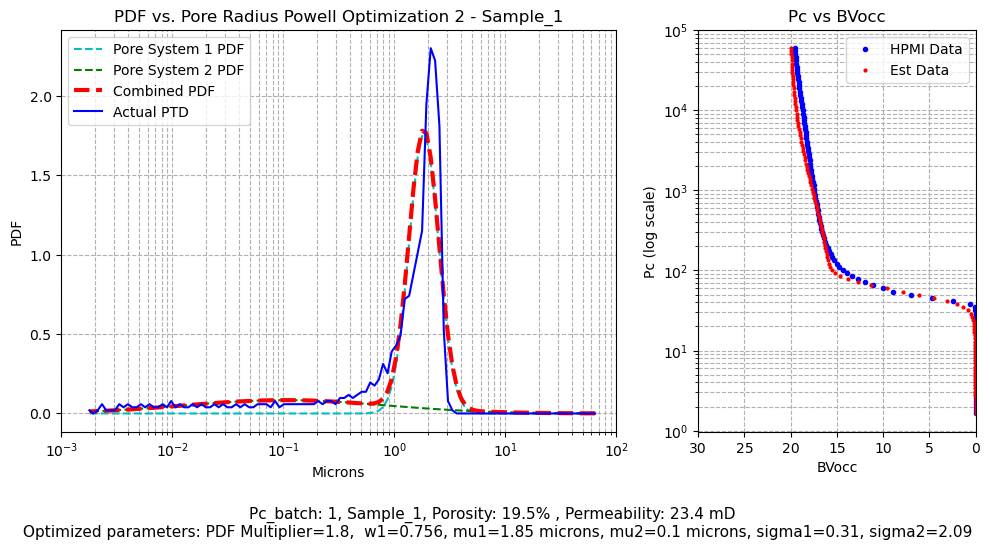





Final minimized error (MSE): 0.0002105305691783429


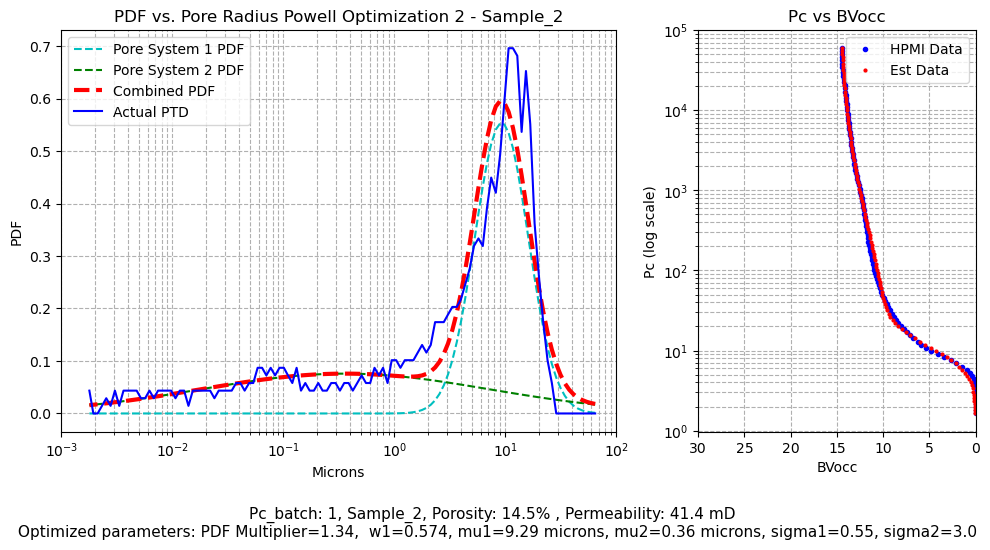





Final minimized error (MSE): 0.00013755688829637203


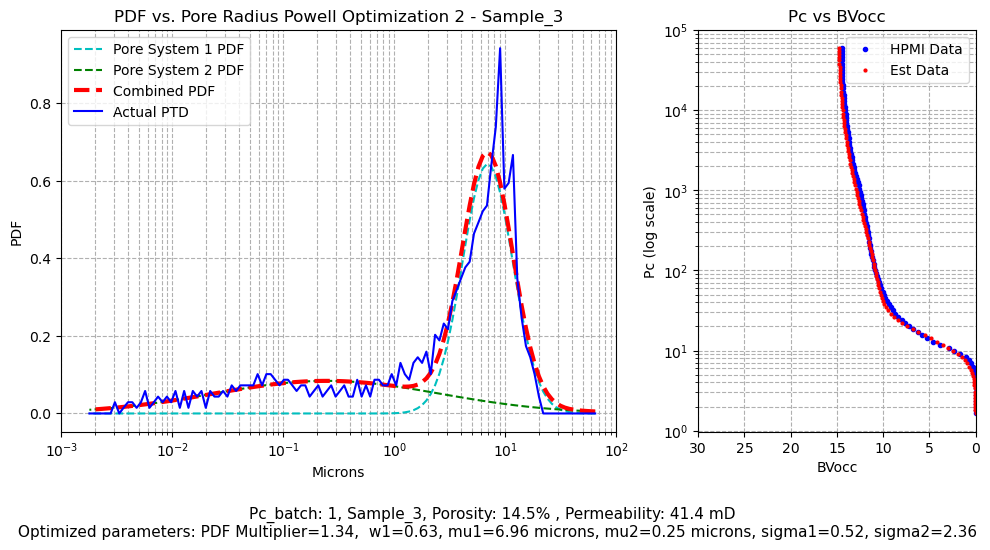





Final minimized error (MSE): 7.409556613962815e-05


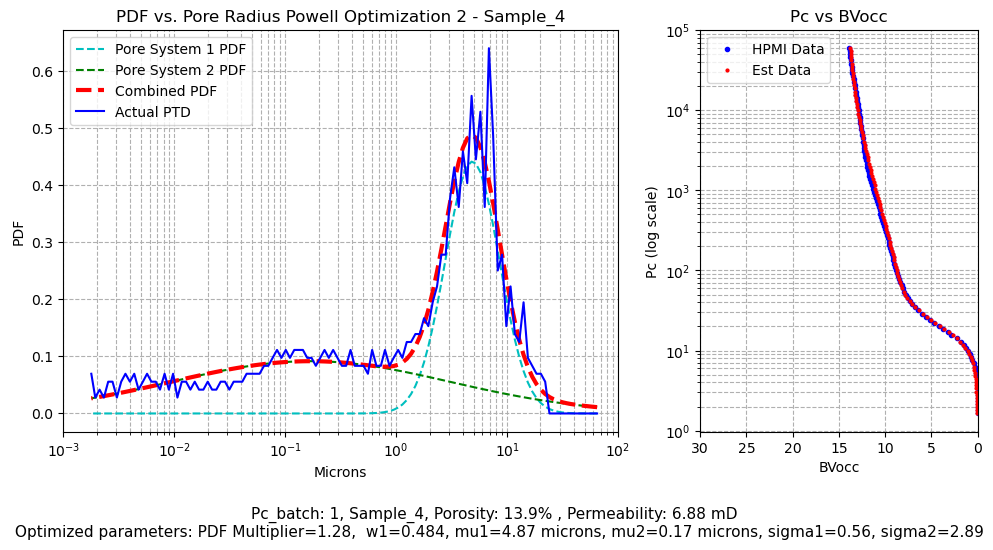





Final minimized error (MSE): 3.232963475376601e-05


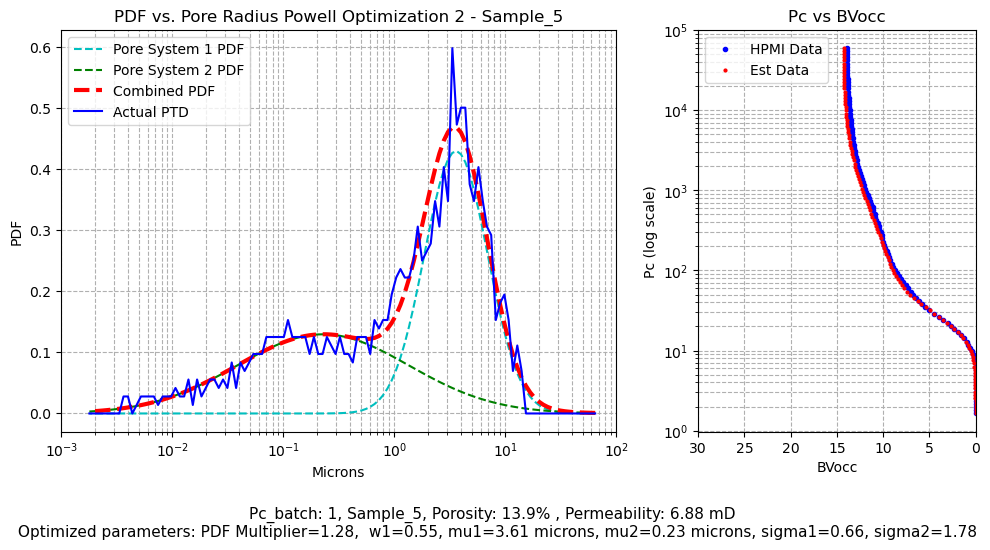





Final minimized error (MSE): 8.892627925816195e-05


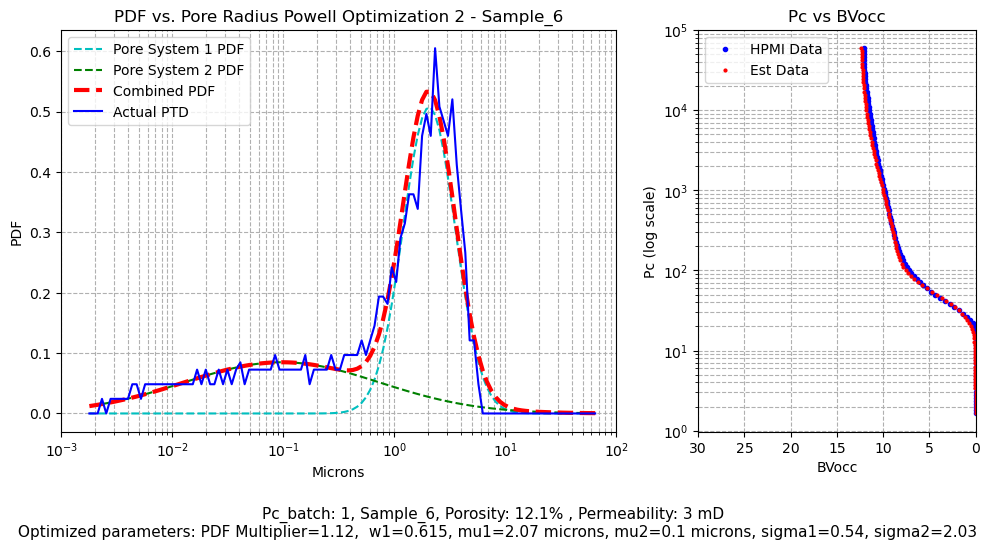





Final minimized error (MSE): 0.00021102072678506718


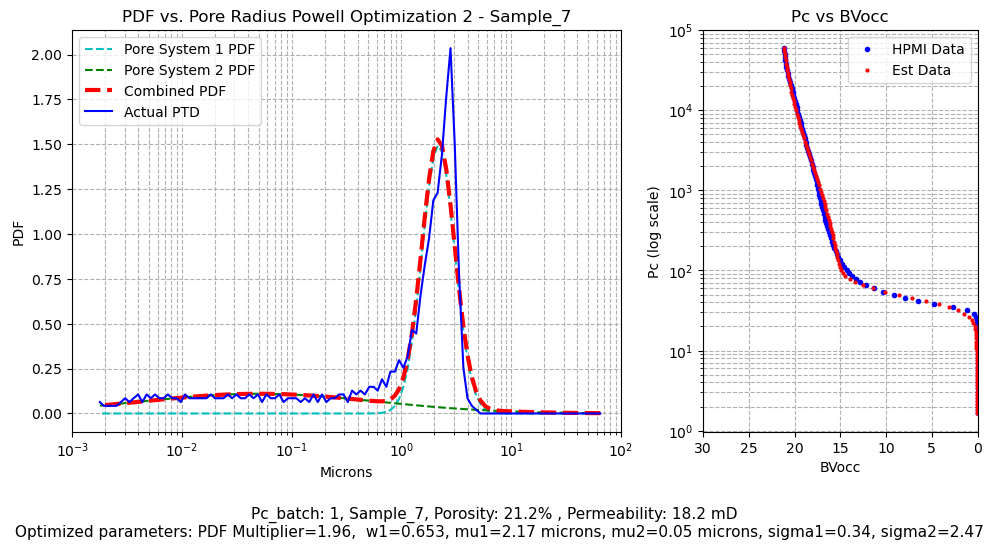





Final minimized error (MSE): 0.00014545870714461777


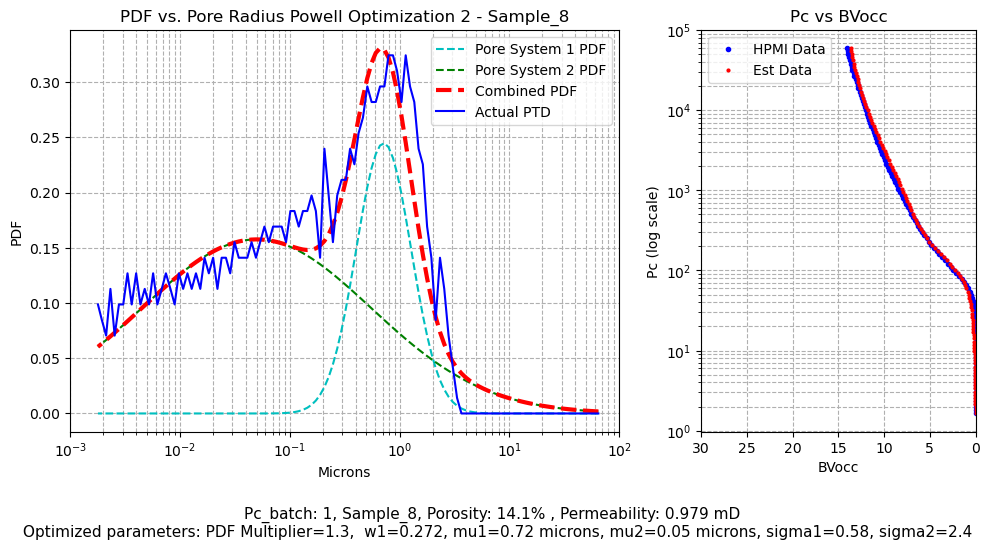





Final minimized error (MSE): 0.0003053007313271632


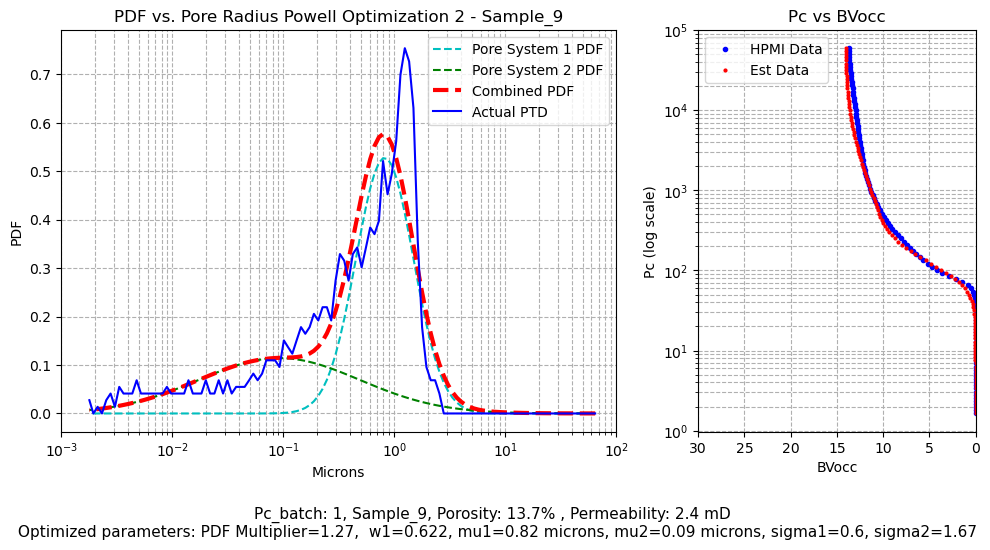





Final minimized error (MSE): 0.00047518390754924345


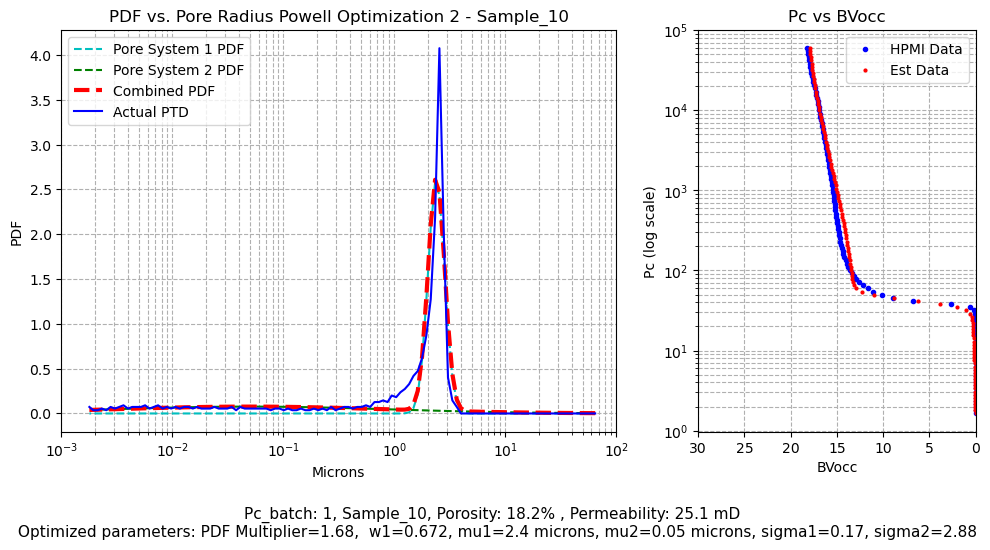





Final minimized error (MSE): 0.0003180645660655483


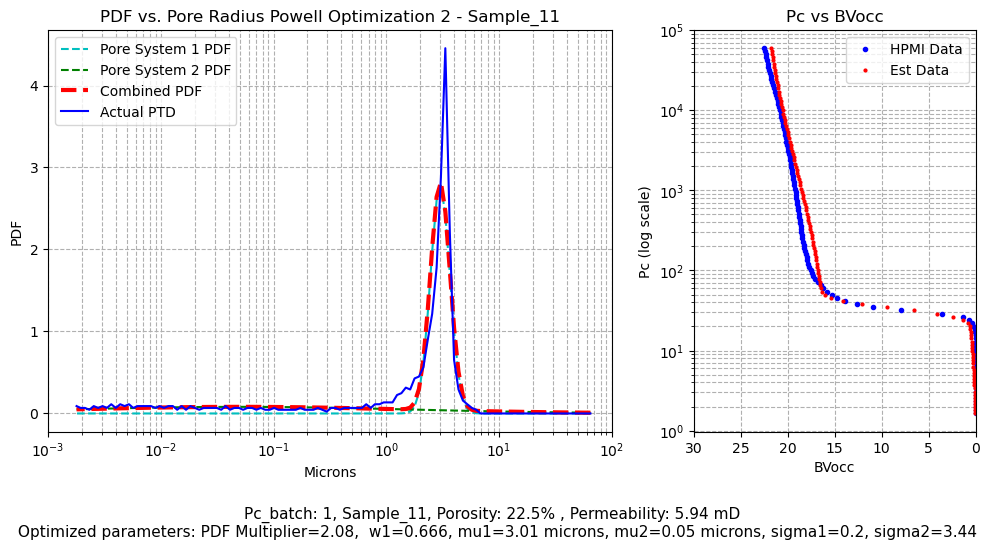





Final minimized error (MSE): 0.00039307510908129304


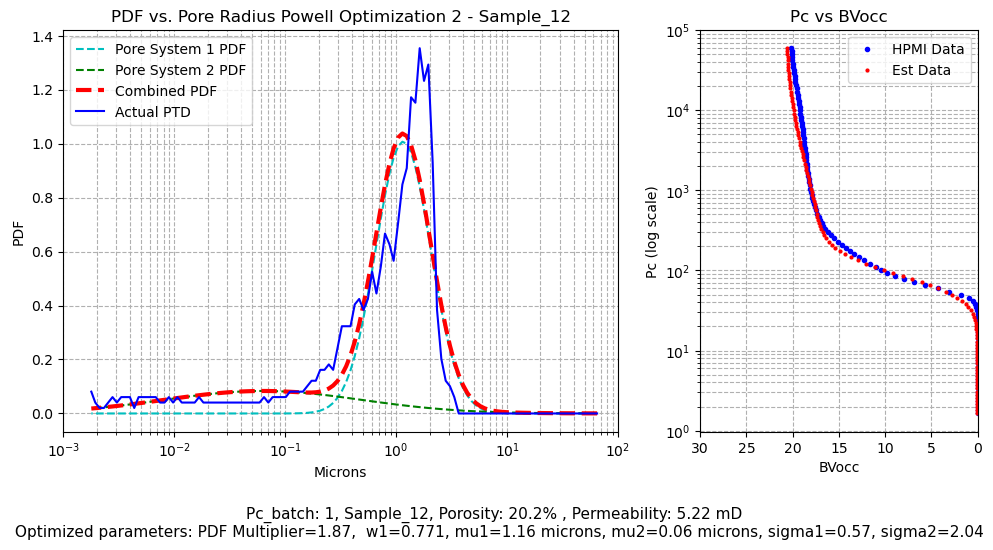





Final minimized error (MSE): 0.00012889559902539474


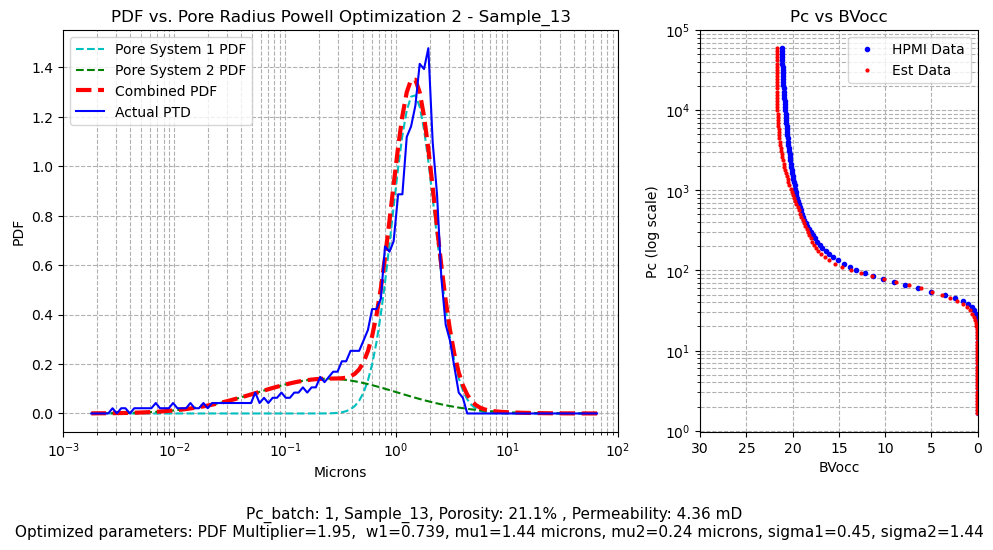





Final minimized error (MSE): 0.00042468760878787545


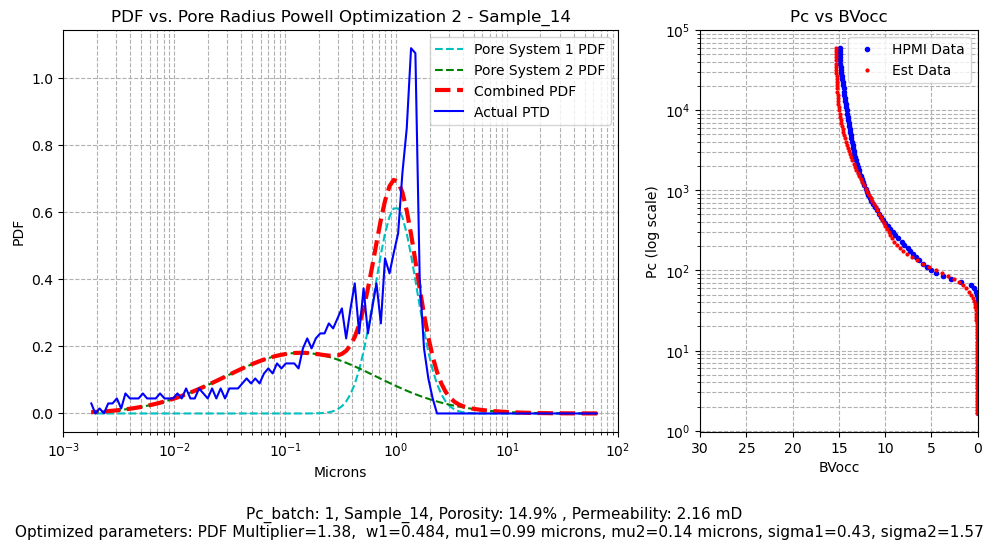





Final minimized error (MSE): 0.00030902010935831425


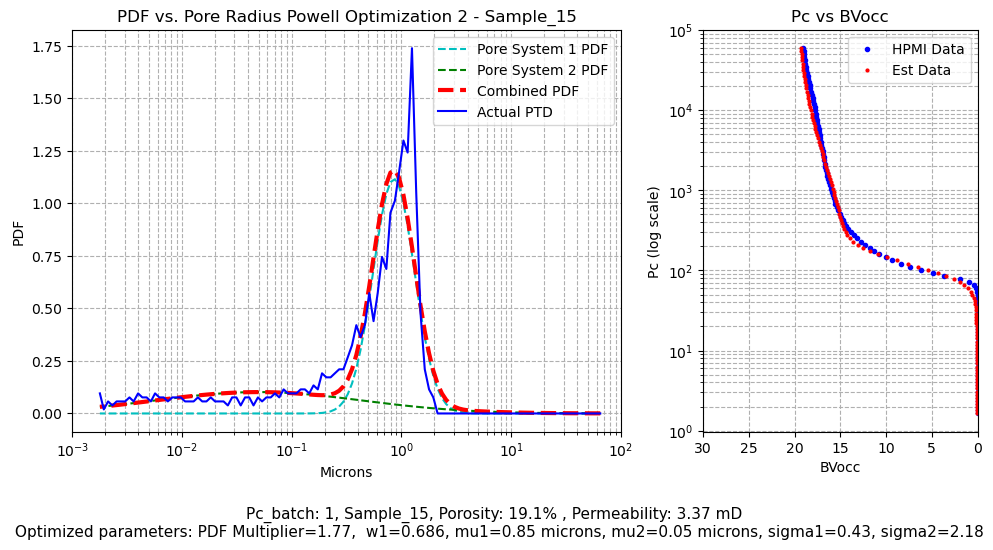





Final minimized error (MSE): 0.00022441747020408642


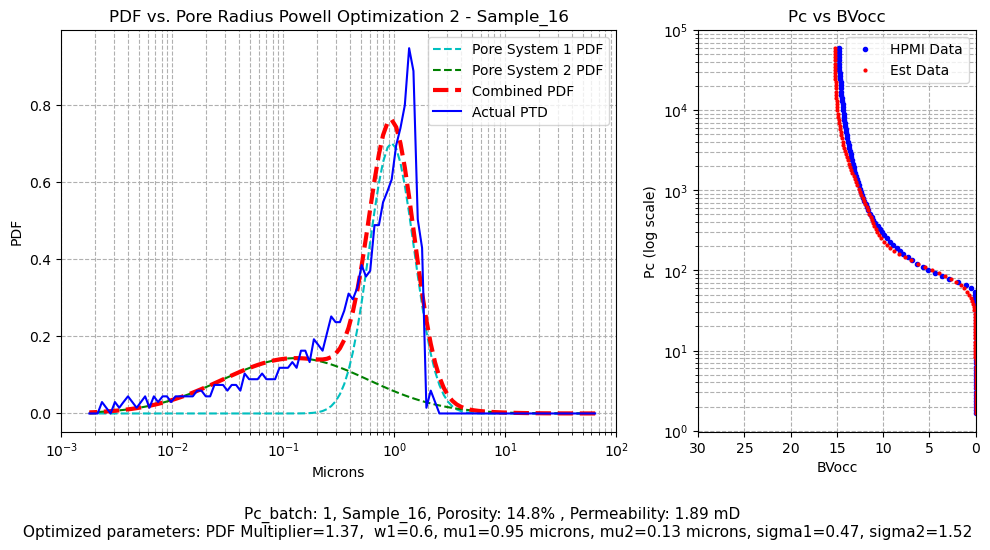





Final minimized error (MSE): 0.00016980311272457024


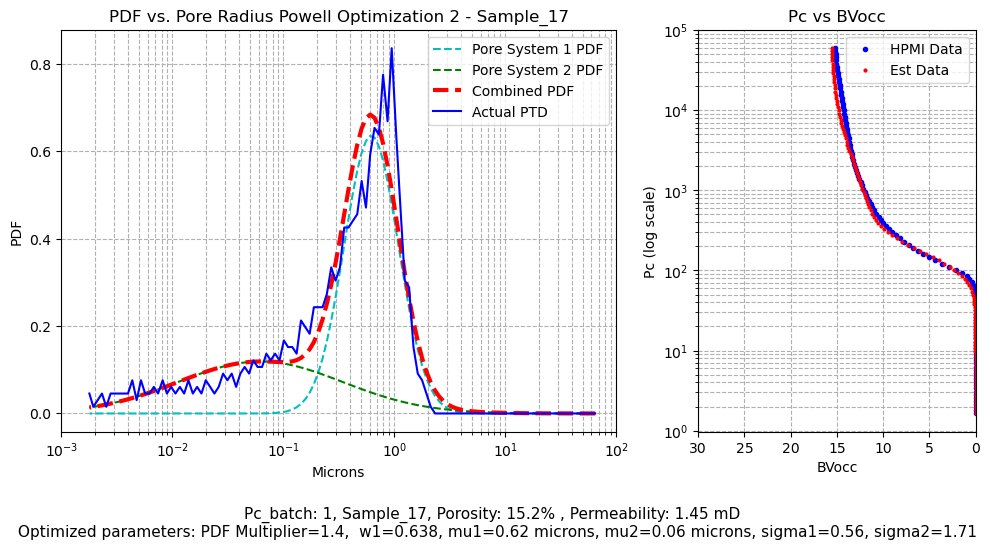





Final minimized error (MSE): 0.0010435481175695175


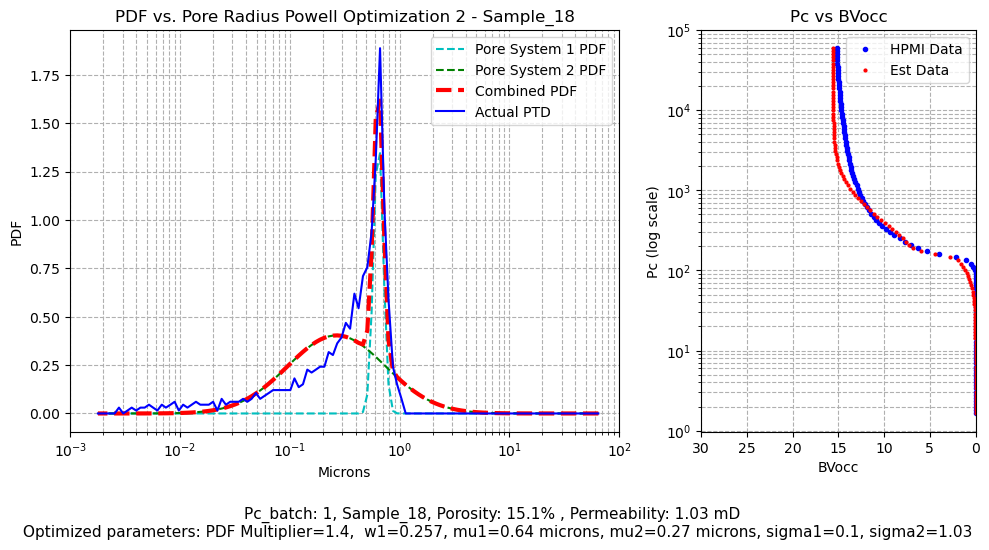





Final minimized error (MSE): 6.034867052426537e-05


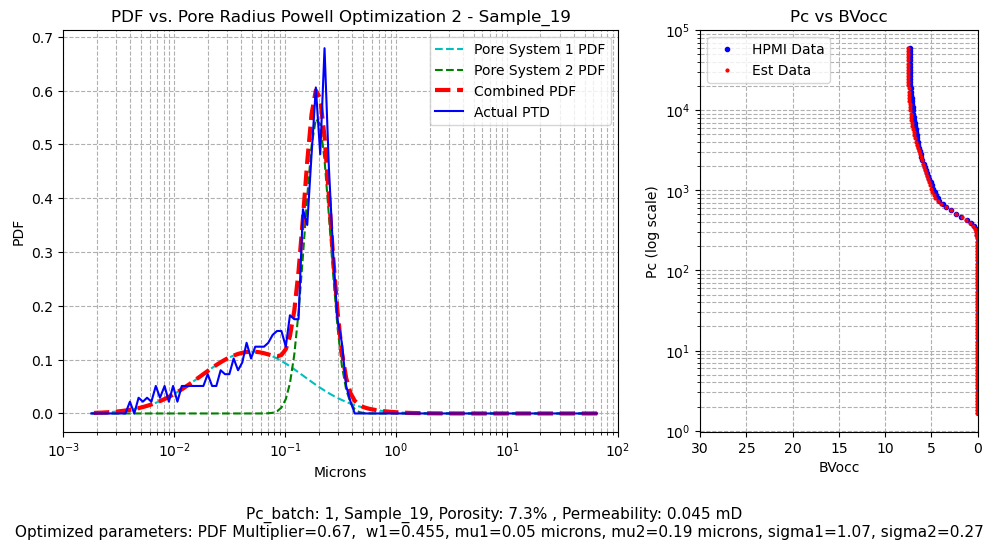





Final minimized error (MSE): 6.83488980324703e-05


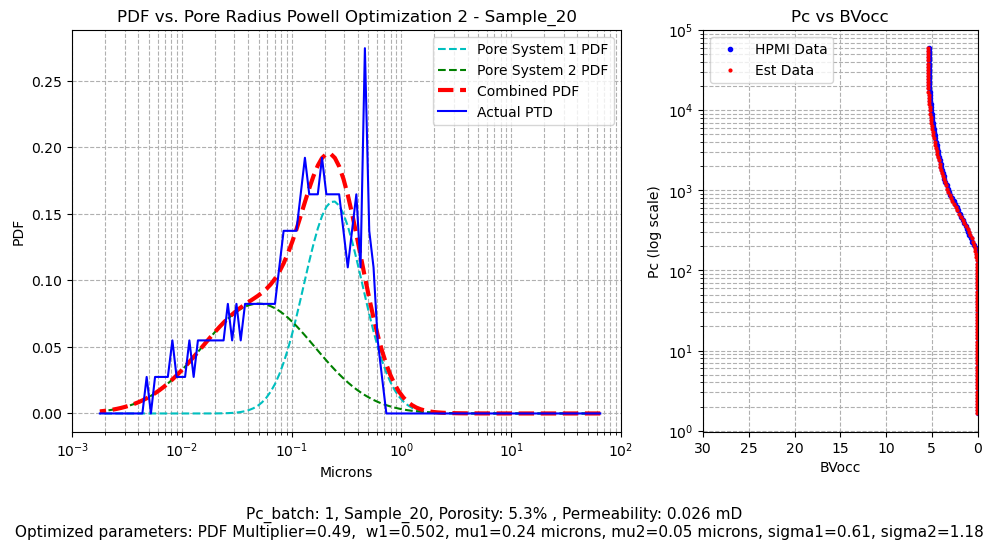





Final minimized error (MSE): 9.718168690899337e-05


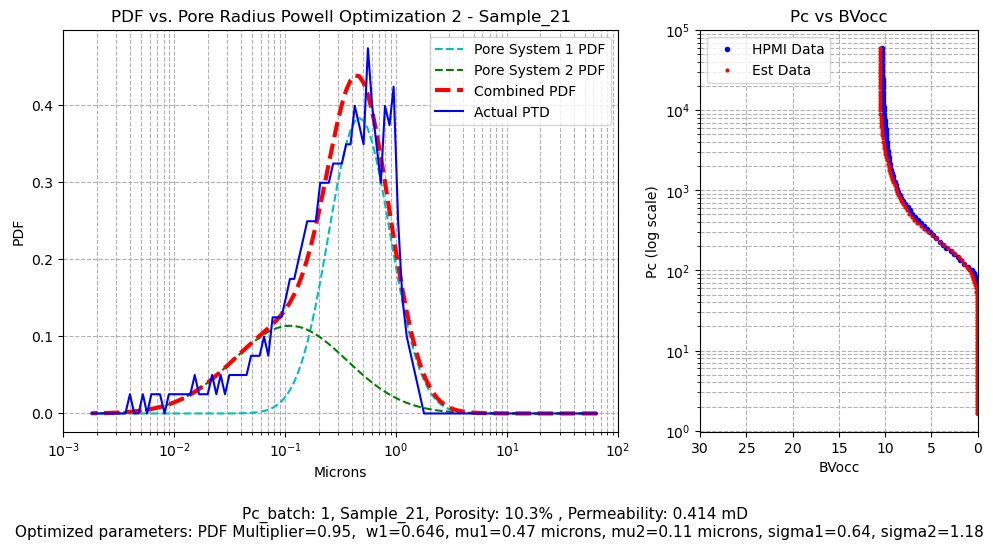





Final minimized error (MSE): 0.00014672590266851264


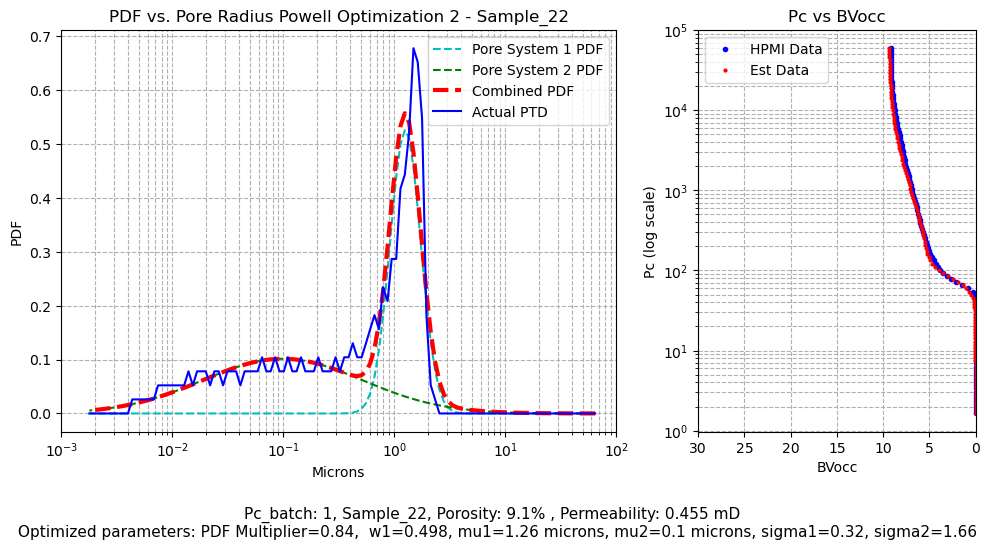





Final minimized error (MSE): 0.00014845636965666315


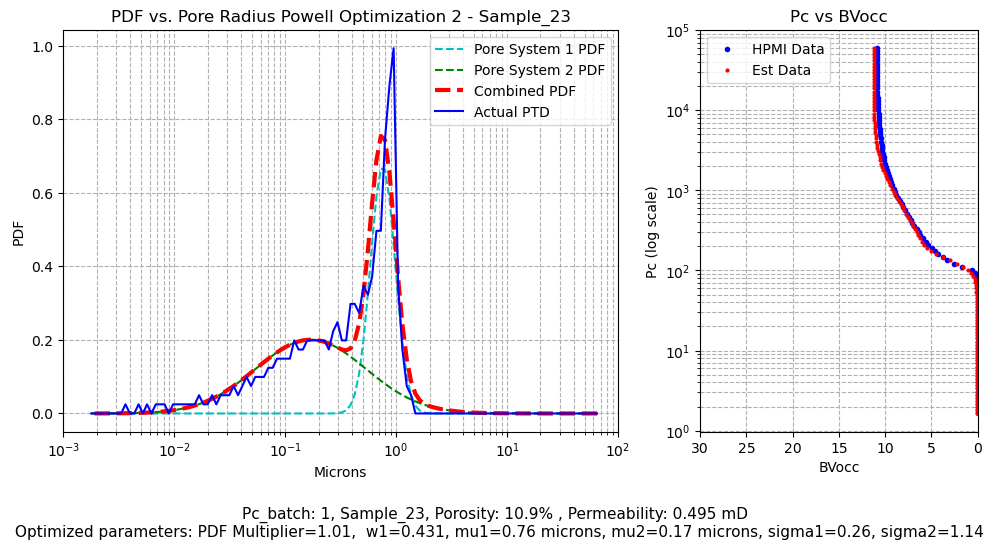





Final minimized error (MSE): 0.0008607424866995102


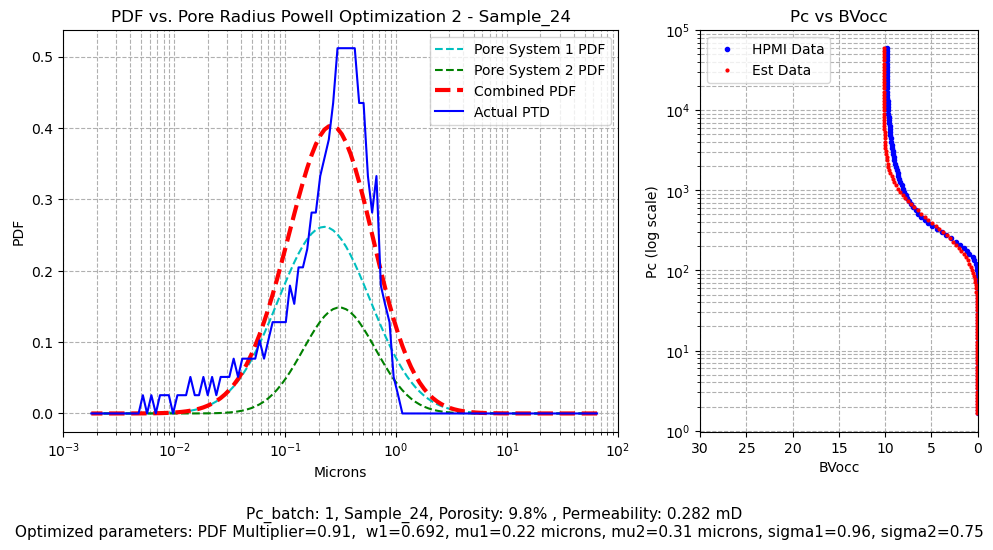





Final minimized error (MSE): 0.00018171556953196588


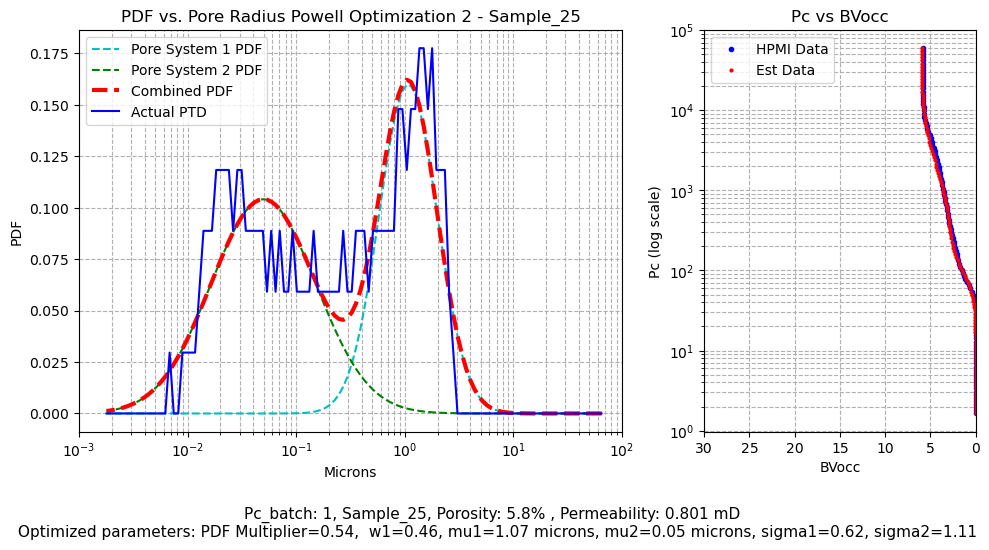





Final minimized error (MSE): 0.0001006847694750604


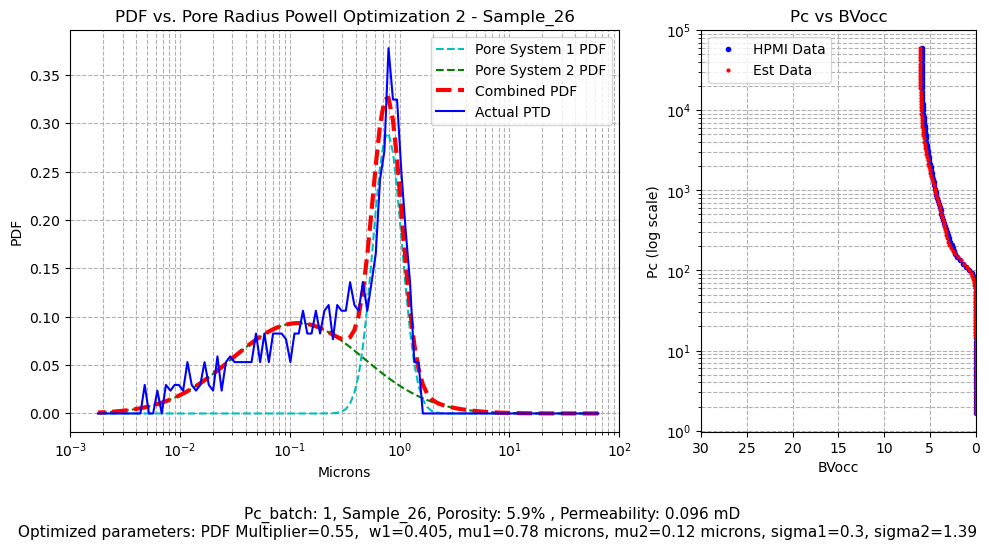





Final minimized error (MSE): 0.00013748664352397362


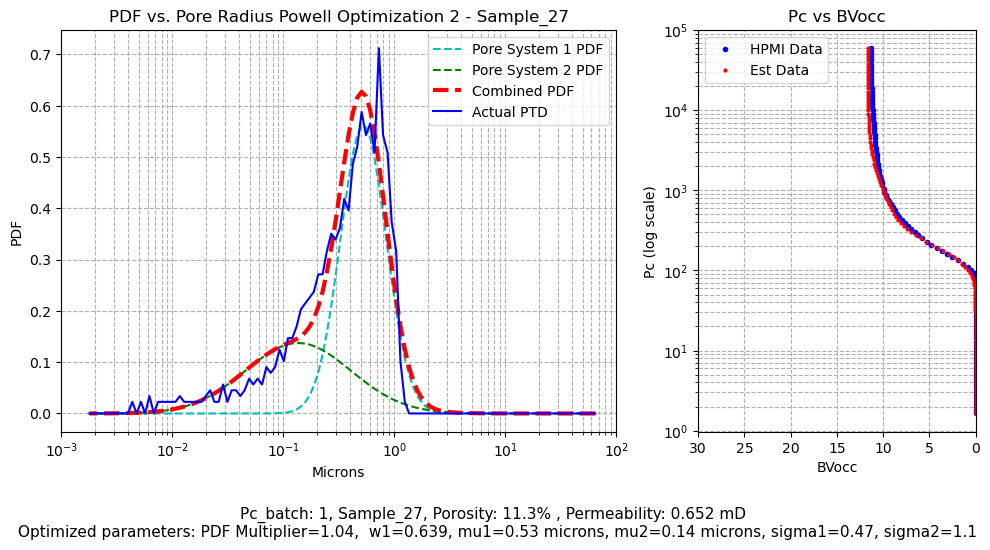





Final minimized error (MSE): 0.00019473584473030773


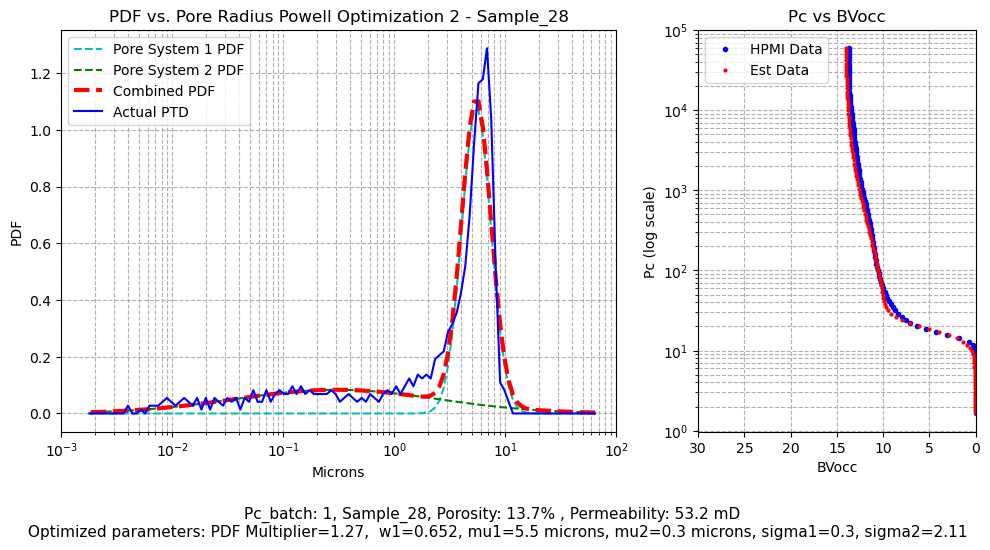





Final minimized error (MSE): 0.00010278539997380862


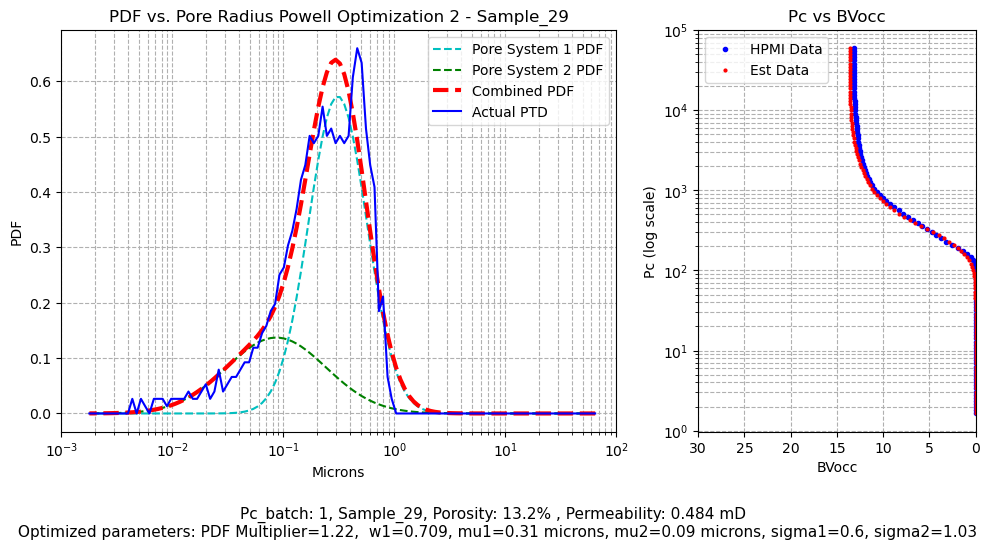





Final minimized error (MSE): 0.0005055203958132137


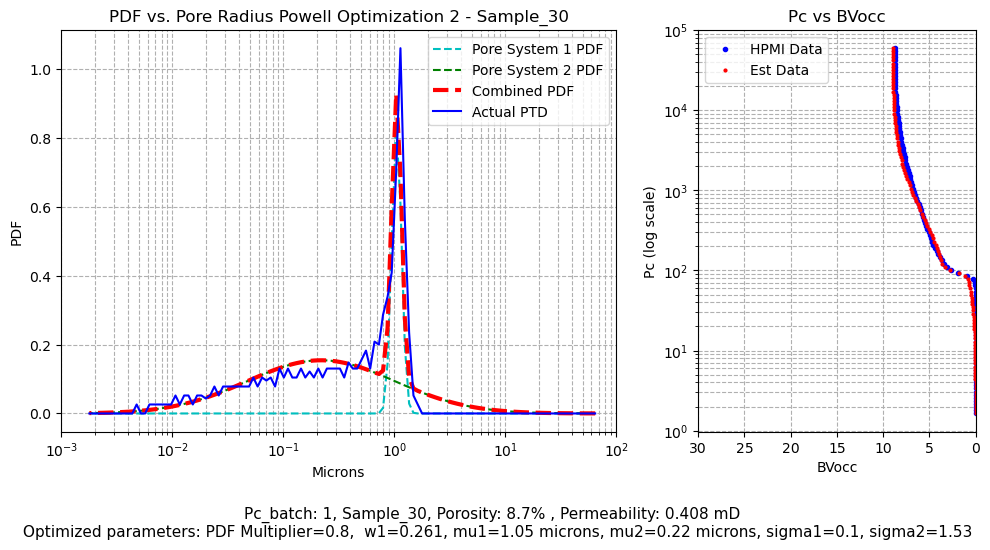





Final minimized error (MSE): 0.0003026765589358396


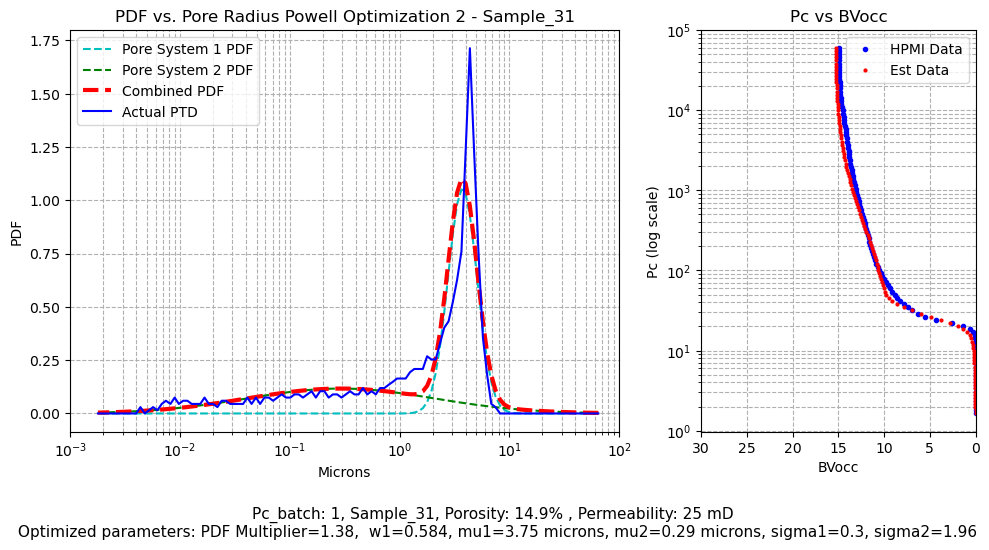





Final minimized error (MSE): 4.096740503439353e-05


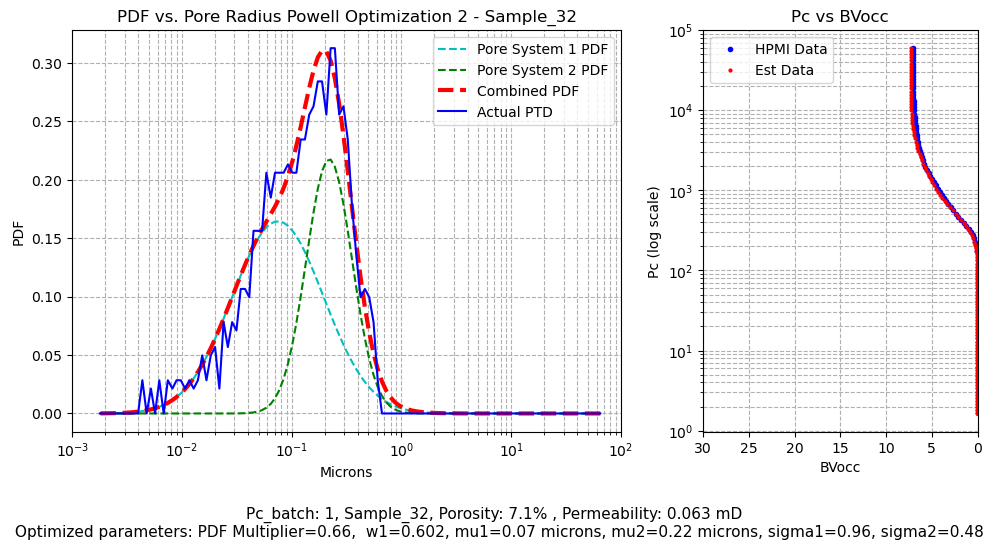





Final minimized error (MSE): 4.8468753333758687e-05


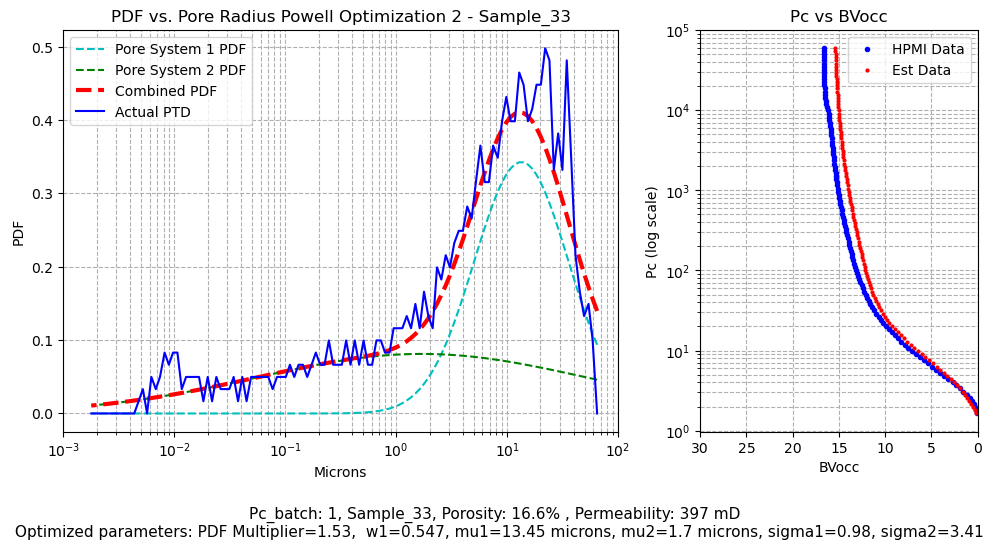





Final minimized error (MSE): 6.89684498177808e-05


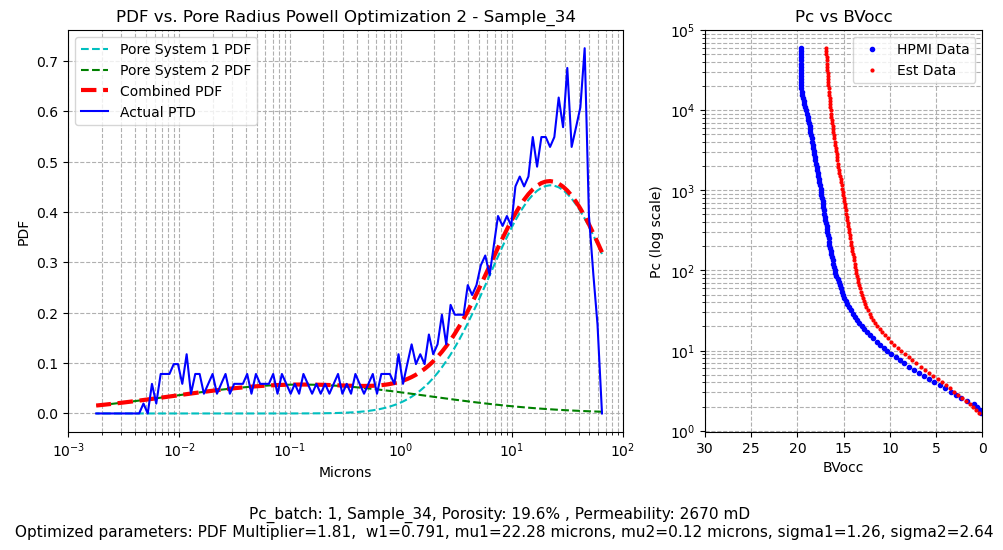





Final minimized error (MSE): 0.0006238255391908058


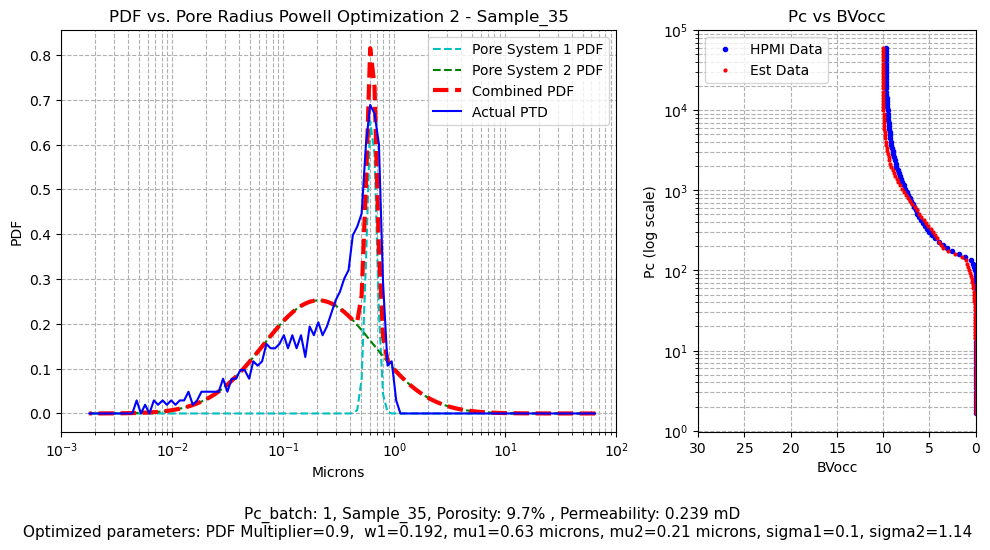

In [6]:


# Loop through all samples
for Sample in data_dict.keys():
    sample_data = data_dict[Sample]

    porosity_sample = sample_data['Porosity (%)']
    perm_sample = sample_data['Permeability']

    Pc = sample_data['Pc']
    Sw = sample_data['Sw']
    BVocc = ((100 - Sw) / 100) * porosity_sample

    dbvocc = np.diff(BVocc)  # diff of BVocc for distribution, but lose one element in the array
    dbvocc = np.insert(dbvocc, 0, 0)  # Our final dbvocc after adding a zero at the start

    mul = 0.0924 * porosity_sample + 0.0002

    pore_systems = 2

    # Model function (unchanged)
    def model_function(w1, mu1, mu2, sigma1, sigma2):
        if pore_systems == 2:
            w2 = 1 - w1
        else:
            w1 = 1
            w2 = 0

        # Generate x-values for pore throat radii on a log scale
        x_values = ((2 * 367) / (Pc * 69035) * 10**4)

        # Calculate the PDFs for log-normal distributions
        pdf1 = mul * w1 * (1 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(- (np.log(x_values) - mu1)**2 / (2 * sigma1**2))
        pdf2 = mul * w2 * (1 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(- (np.log(x_values) - mu2)**2 / (2 * sigma2**2))

        # Combine PDFs
        combined_pdf = pdf1 + pdf2

        # Sum up this distribution for a Pc curve
        BV_new = np.cumsum(combined_pdf)

        # Create the plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [2, 1]})

        # Plot PDF with reversed axes
        ax1.plot(x_values, pdf1, 'c--', label='Pore System 1 PDF')
        ax1.plot(x_values, pdf2, 'g--', label='Pore System 2 PDF')
        ax1.plot(x_values, combined_pdf, 'r--', label='Combined PDF', lw=3)
        ax1.plot(x_values, dbvocc, 'b-', label='Actual PTD')
        ax1.set_yscale('linear')
        ax1.set_xscale('log')
        ax1.set_xlim(0.001, 100)
        ax1.set_xlabel('Microns')
        ax1.set_ylabel('PDF')
        ax1.set_title(f'PDF vs. Pore Radius Powell Optimization 2 - {Sample}')
        ax1.grid(True, which="both", ls="--")
        ax1.legend()

        # Add the text below the plot
        text_string = (f'Pc_batch: {Pc_batch}, {Sample}, Porosity: {porosity_sample}% ,'
                       f' Permeability: {perm_sample} mD \n '
                       f'Optimized parameters: PDF Multiplier={round(mul, 2)},  w1={round(w1_opt, 3)}, '
                       f'mu1={round(np.exp(mu1_opt), 2)} microns, mu2={round(np.exp(mu2_opt), 2)} microns, '
                       f'sigma1={round(sigma1_opt, 2)}, sigma2={round(sigma2_opt, 2)}')

        # Adjust the position of the text as needed
        plt.figtext(0.5, -0.08, text_string, ha="center", fontsize=11, wrap=True)

        # Plot the actual data with markers only
        ax2.semilogy(BVocc, Pc, 'bo', markersize=3, label='HPMI Data')
        ax2.semilogy(BV_new, Pc, 'ro', markersize=2, label='Est Data')
        ax2.set_yscale('log')
        ax2.set_xlim(30, 0)
        ax2.set_title('Pc vs BVocc')
        ax2.set_ylabel('Pc (log scale)')
        ax2.set_xlabel('BVocc')
        ax2.grid(True, which="both", ls="--")
        ax2.legend()


        '''
        # Define the subdirectory where you want to save the plots
        output_dir = 'Plots'
        os.makedirs(output_dir, exist_ok=True)

        # Save the plot with a custom filename in the Plots subdirectory
        filename = os.path.join(output_dir, f'Plot_Pc_Batch{Pc_batch}_{Sample}_Optimize_Method2.png')
        plt.savefig(filename, bbox_inches='tight')'''
        
        plt.tight_layout()
        # Display the plot
        plt.show()

        return fig

    # Objective function (unchanged)
    def objective_function(params, Pc, BVocc, dbvocc):
        w1, mu1, mu2, sigma1, sigma2 = params

        if pore_systems == 2:
            w2 = 1 - w1
        else:
            w1 = 1
            w2 = 0

        x_values = ((2 * 367) / (Pc * 69035) * 10**4)

        pdf1 = mul * w1 * (1 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(- (np.log(x_values) - mu1)**2 / (2 * sigma1**2))
        pdf2 = mul * w2 * (1 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(- (np.log(x_values) - mu2)**2 / (2 * sigma2**2))

        combined_pdf = pdf1 + pdf2
        BV_new = np.cumsum(combined_pdf)

        # Normalize the BVocc and BV_new to avoid scale issues
        BVocc_normalized = BVocc / np.max(BVocc)
        BV_new_normalized = BV_new / np.max(BV_new)

        # Calculate the error (mean squared error) between the actual and estimated data
        error = np.mean((BVocc_normalized - BV_new_normalized)**2)

        return error

    
    # Initial guess for optimization
    initial_guess = [0.7, np.log(6), np.log(0.1), 0.9, 0.7]  # w1, mu1, mu2, sigma1, sigma2
    
    # Define bounds for each parameter
    bounds = [
        (0, 1),          # w1
        (-3, 6),         # mu1
        (-3, 6),         # mu2
        (0.1, 4),        # sigma1
        (0.1, 4)         # sigma2
    ]

    # Perform the optimization with Powell method (unchanged)
    result = minimize(objective_function, initial_guess, args=(Pc, BVocc, dbvocc), method='Powell', bounds=bounds)


    print()
    print()
    print()
    print()
    minimized_error = result.fun
    print(f"Final minimized error (MSE): {minimized_error}")
    error_threshold = 0.05  # Define an appropriate threshold
    

    
    # Extract optimized parameters
    optimized_params = result.x
    w1_opt, mu1_opt, mu2_opt, sigma1_opt, sigma2_opt = optimized_params

    #print(f"Optimized parameters: PDF Multiplier={round(mul, 3)}, w1={round(w1_opt, 3)}, mu1={round(np.exp(mu1_opt), 2)}, mu2={round(np.exp(mu2_opt), 2)}, sigma1={round(sigma1_opt, 2)}, sigma2={round(sigma2_opt, 2)}")

    # Use optimized parameters to generate the final plot
    fig = model_function(w1_opt, mu1_opt, mu2_opt, sigma1_opt, sigma2_opt)

    # Optionally save the optimization results to an Excel file
    output_excel_file = 'Sample_Optimization_Results_Optimization_Method2.xlsx'

    if minimized_error > error_threshold:
        print("Bad result, optimization error is too high.")
    else:
        #print("Good result, acceptable optimization error.")

    
        data_to_save = {
            'Pc_batch': Pc_batch,
            'Sample': Sample,
            'Porosity (%)': porosity_sample,
            'Permeability (mD)': perm_sample,
            'PDF Multiplier': round(mul, 3),
            'w1': round(w1_opt, 3),
            'mu1 (microns)': round(np.exp(mu1_opt), 2),
            'mu2 (microns)': round(np.exp(mu2_opt), 2),
            'sigma1': round(sigma1_opt, 2),
            'sigma2': round(sigma2_opt, 2),
            'minimized_error': round(minimized_error, 6),
        }
    
        df = pd.DataFrame([data_to_save])
    
        # Check if the file already exists
        if os.path.exists(output_excel_file):
            with pd.ExcelWriter(output_excel_file, mode='a', if_sheet_exists='overlay', engine='openpyxl') as writer:
                df.to_excel(writer, index=False, header=False, startrow=writer.sheets['Sheet1'].max_row)
        else:
            df.to_excel(output_excel_file, index=False)

